In [1]:

library(dplyr)
library(stringr)
library(ggplot2)
library(patchwork)

model_name = "model8"
n_bootstrap=0
equiv_toLowest=TRUE
exclude_triplet = FALSE
exclude_CpG= FALSE

tmp_file_path = "../../../"


model_desc_modify = ""
if (equiv_toLowest==TRUE){
    model_desc_modify = paste(model_desc_modify,"_equiv_toLowest",sep="")}
if (n_bootstrap==1000){
    model_desc_modify = paste(model_desc_modify,"_boot1k",sep="")
} else if (n_bootstrap==10000){
    model_desc_modify = paste(model_desc_modify,"_boot10k",sep="")
}
if (exclude_CpG==TRUE){
    model_desc_modify = paste(model_desc_modify,"_noCpG",sep="")}
if (exclude_triplet==TRUE){
    model_desc_modify = paste(model_desc_modify,"_noTriplets",sep="")}

blood_coefs <- read.csv(paste(tmp_file_path,"data/blood/dataframes/",model_name,"/blood_forLiver_coefDF",model_desc_modify,".csv",sep=""))
germline_coefs <- read.csv(paste(tmp_file_path,"data/germline/dataframes/",model_name,"/germline_forLiver_coefDF",model_desc_modify,".csv",sep=""))
skin_coefs <- read.csv(paste(tmp_file_path,"data/skin/dataframes/",model_name,"/skin_forLiver_coefDF",model_desc_modify,".csv",sep=""))
liver_coefs <- read.csv(paste(tmp_file_path,"data/liver/dataframes/",model_name,"/liver_coefDF",model_desc_modify,".csv",sep=""))

#rename columns tp include the tissue in the colanme (for later merging)
for(i in 2:ncol(blood_coefs)) names(blood_coefs)[names(blood_coefs) == colnames(blood_coefs)[i]] = paste("blood_",colnames(blood_coefs)[i],sep="")
for(i in 2:ncol(germline_coefs)) names(germline_coefs)[names(germline_coefs) == colnames(germline_coefs)[i]] = paste("germline_",colnames(germline_coefs)[i],sep="")
for(i in 2:ncol(liver_coefs)) names(liver_coefs)[names(liver_coefs) == colnames(liver_coefs)[i]] = paste("liver_",colnames(liver_coefs)[i],sep="")
for(i in 2:ncol(skin_coefs)) names(skin_coefs)[names(skin_coefs) == colnames(skin_coefs)[i]] = paste("skin_",colnames(skin_coefs)[i],sep="")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
blood_coefs

name,blood_value,blood_std_err,blood_z_val,blood_p_val,blood_t_stat
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
tripletACG,0.253337158,0.03635627,6.9681829,3.210606e-12,6.9681829
Repeats.0,0.224951085,0.02758656,8.1543722,3.509983e-16,8.1543722
tripletCCG,0.143029557,0.03256351,4.3923259,1.121444e-05,4.3923259
tripletGCG,0.120663192,0.02959202,4.0775584,4.551110e-05,4.0775584
laminB1.10000,0.114499591,0.02668279,4.2911401,1.777581e-05,4.2911401
tripletTCG,0.095870874,0.02838300,3.3777563,7.307981e-04,3.3777563
annotationUTR5,0.070547730,0.02621495,2.6911254,7.121142e-03,2.6911254
Chromosomechr20,0.065033687,0.02561439,2.5389509,1.111854e-02,2.5389509
Chromosomechr11,0.064950368,0.02897515,2.2415889,2.498795e-02,2.2415889


In [17]:


# colnames(blood_coefs)[which(colnames(blood_coefs) %in% c("mean_est","quant025","quant975"))]<-c("blood_mean_est","blood_quant025","blood_quant975")
# colnames(germline_coefs)[which(colnames(germline_coefs) %in% c("mean_est","quant025","quant975"))]<-c("germline_mean_est","germline_quant025","germline_quant975")
# colnames(liver_coefs)[which(colnames(liver_coefs) %in% c("mean_est","quant025","quant975"))]<-c("liver_mean_est","liver_quant025","liver_quant975")
# colnames(skin_coefs)[which(colnames(skin_coefs) %in% c("mean_est","quant025","quant975"))]<-c("skin_mean_est","skin_quant025","skin_quant975")


all_coefs <- merge(blood_coefs[c("name","blood_mean_est","blood_quant025","blood_quant975")],germline_coefs[c("name","germline_mean_est","germline_quant025","germline_quant975")])#https://www.statmethods.net/management/merging.html
all_coefs <- merge(all_coefs,liver_coefs[c("name","liver_mean_est","liver_quant025","liver_quant975")])
all_coefs <- merge(all_coefs,skin_coefs[c("name","skin_mean_est","skin_quant025","skin_quant975")])

#https://stackoverflow.com/questions/18503177/r-apply-function-on-specific-dataframe-columns
all_coefs$all_mean_est <- apply(all_coefs[c("blood_mean_est","liver_mean_est","germline_mean_est","skin_mean_est")], 1,mean)

#create col that categorizes 
all_coefs<-all_coefs %>%
    mutate(type = case_when(        
        str_detect(name, 'percent') ~ 'sequence',
        str_detect(name, 'Chromosome') ~ 'sequence',
        str_detect(name, 'Repeats') ~ 'sequence',
        str_detect(name, 'site') ~ 'sequence',
        str_detect(name, 'annot') ~ 'sequence',
        str_detect(name, 'content') ~ 'sequence',
        str_detect(name, 'CpG') ~ 'sequence',
        
        str_detect(name, 'triplet') ~ 'triplet',
        
        str_detect(name, 'DNAse') ~ 'tissue_specific',
        str_detect(name, 'Transcription') ~ 'tissue_specific',
        str_detect(name, 'H3k') ~ 'tissue_specific',
        str_detect(name, 'methyl') ~ 'tissue_specific',
        
        str_detect(name, 'recomb') ~ 'global',
        str_detect(name, 'lamin') ~ 'global',
        str_detect(name, 'Replication') ~ 'global',
        str_detect(name, 'dist_rep') ~ 'global',
        
        str_detect(name, 'Intercept') ~ 'intercept',
    ))
#create col that categorizes 
all_coefs<-all_coefs %>%
    mutate(color_name = case_when(        
        str_detect(type, 'sequence') ~ "#7CAE00",
        str_detect(type, 'triplet') ~ "#C77CFF",
        str_detect(type, 'tissue_specific') ~ '#00BFC4',
        str_detect(type, 'global') ~ '#F8766D',
        str_detect(type, 'intercept') ~ "darkgrey",
    ))

all_sign_coefs<-filter(all_coefs[order(-all_coefs$blood_mean_est),],(blood_quant025*blood_quant975>0)|(germline_quant025*germline_quant975>0)|(liver_quant025*liver_quant975>0)|(skin_quant025*skin_quant975>0))
all_insign_coefs<-filter(all_coefs[order(-all_coefs$blood_mean_est),],(blood_quant025*blood_quant975<0)&(germline_quant025*germline_quant975<0)&(liver_quant025*liver_quant975<0)&(skin_quant025*skin_quant975<0))

all_sign_coefs$all_mean_est<-rowMeans(subset(all_sign_coefs, select = c(blood_mean_est, germline_mean_est,liver_mean_est,skin_mean_est)), na.rm =FALSE)
all_sign_coefs$all_stdDev <- apply(all_sign_coefs[c("blood_mean_est","germline_mean_est","liver_mean_est","skin_mean_est")],1,function(x)sd(x))#/sqrt(length(x)
all_sign_coefs$all_stdErr <- all_sign_coefs$all_stdDev/sqrt(4)
all_sign_coefs$all_coefDev <- all_sign_coefs$all_stdDev/all_sign_coefs$all_mean_est

                          
colors_ggplot <- c(sequence = "#7CAE00", triplet = "#C77CFF", global ='#F8766D', tissue_specific = '#00BFC4', intercept = "darkgrey")
all_sign_coefs$all_coefDev_by100 <- all_sign_coefs$all_coefDev/100
                                   
# p1 <- ggplot(data=all_sign_coefs[all_sign_coefs$name!="tripletACT",],aes(x = reorder(name, -all_mean_est), y = all_mean_est,fill=type))+
p1 <- ggplot(data=all_sign_coefs,aes(x = reorder(name, -all_mean_est), y = all_mean_est,fill=type))+
    geom_bar(stat="identity")+
    xlab(paste("predictors",sep=" "))+
    ylab("average value for bootstrap mean estimate of all tissues")+
#     geom_text(aes(y=all_mean_est+0.05*sign(all_mean_est),label=name),angle = 90,size=2)+#bars next to bar value 
    theme(text = element_text(size=10),axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+#geom_text(aes(y=-0.05*sign(mean_est),label=name),angle = 90,size=2)+#labels next to the bottom (0 line) of bars 
    scale_fill_manual(values=colors_ggplot)+
    geom_errorbar(aes(ymin=all_mean_est-all_coefDev_by100, ymax=all_mean_est+all_coefDev_by100), width=.2,position=position_dodge(.9),color="darkslategrey")
# p2 <-ggplot(data=all_sign_coefs,aes(x = reorder(name, -all_mean_est), y = all_mean_est,fill=type))+
#     geom_bar(stat="identity")+
#     xlab(paste("predictors",sep=" "))+
#     ylab("average value for bootstrap mean estimate of all tissues")+
# #     geom_text(aes(y=all_mean_est+0.05*sign(all_mean_est),label=name),angle = 90,size=2)+#bars next to bar value 
#     theme(text = element_text(size=10),axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+#geom_text(aes(y=-0.05*sign(mean_est),label=name),angle = 90,size=2)+#labels next to the bottom (0 line) of bars 
#     scale_fill_manual(values=colors_ggplot)+
#     geom_errorbar(aes(ymin=all_mean_est-all_coefDev_by100, ymax=all_mean_est+all_coefDev_by100), width=.2,position=position_dodge(.9),color="darkslategrey")
p3 <-ggplot(data=all_sign_coefs,aes(x = reorder(name, -all_mean_est), y = all_mean_est,fill=type))+
    geom_bar(stat="identity")+
    xlab(paste("predictors",sep=" "))+
    ylab("average value for bootstrap mean estimate of all tissues")+
#     geom_text(aes(y=all_mean_est+0.05*sign(all_mean_est),label=name),angle = 90,size=2)+#bars next to bar value 
    theme(text = element_text(size=10),axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+#geom_text(aes(y=-0.05*sign(mean_est),label=name),angle = 90,size=2)+#labels next to the bottom (0 line) of bars 
    scale_fill_manual(values=colors_ggplot)+
    geom_errorbar(aes(ymin=all_mean_est-all_coefDev, ymax=all_mean_est+all_coefDev), width=.2,position=position_dodge(.9),color=all_sign_coefs$color_name)
p<-p3+p1
ggsave(plot = p, width = 22, height = 10, dpi = 300, filename = paste(tmp_file_path,"analysis/global/plots/",model_name,"/coefBarPlot_all_coefDev",model_desc_modify,".pdf",sep=""))


## **violin plot**

In [50]:
all_all_coefs <- (merge(blood_coefs,germline_coefs,on="name"))
all_all_coefs <- (merge(all_all_coefs,liver_coefs,on="name"))
all_all_coefs <- (merge(all_all_coefs,skin_coefs,on="name"))

In [77]:
all_all_coefs<-all_all_coefs[,!(names(all_all_coefs) %in% c("blood_mean_est","blood_quant025","blood_quant975",
                                                     "liver_mean_est","liver_quant025","liver_quant975",
                                                     "germline_mean_est","germline_quant025","germline_quant975",
                                                     "skin_mean_est","skin_quant025","skin_quant975"))]

In [73]:
all_all_coefs$all_mean_est <- all_coefs$all_mean_est #using the mean calcuated from the means (in other df) 
all_all_coefs$type <- all_coefs$type
all_all_coefs$color_name <- all_coefs$color_name

In [83]:
all_all_coefs_long <- all_all_coefs %>% gather(source, coeficient, blood_value_1:skin_value_10000)

In [84]:
head(all_all_coefs_long)

,name,all_mean_est,type,color_name,source,coeficient
,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>
1,(Intercept),-0.176965580,intercept,darkgrey,blood_value_1,-0.287153511
2,annotationregulatory,0.006420837,sequence,#7CAE00,blood_value_1,0.332871080
3,annotationtranscribed,-0.032665491,sequence,#7CAE00,blood_value_1,-0.115891920
4,annotationUTR3,-0.006739626,sequence,#7CAE00,blood_value_1,-0.038144711
5,annotationUTR5,-0.004484695,sequence,#7CAE00,blood_value_1,0.008262494
6,Chromosomechr10,0.002208747,sequence,#7CAE00,blood_value_1,0.001023788


Warning message:
“Removed 377 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 377 rows containing non-finite values (stat_ydensity).”


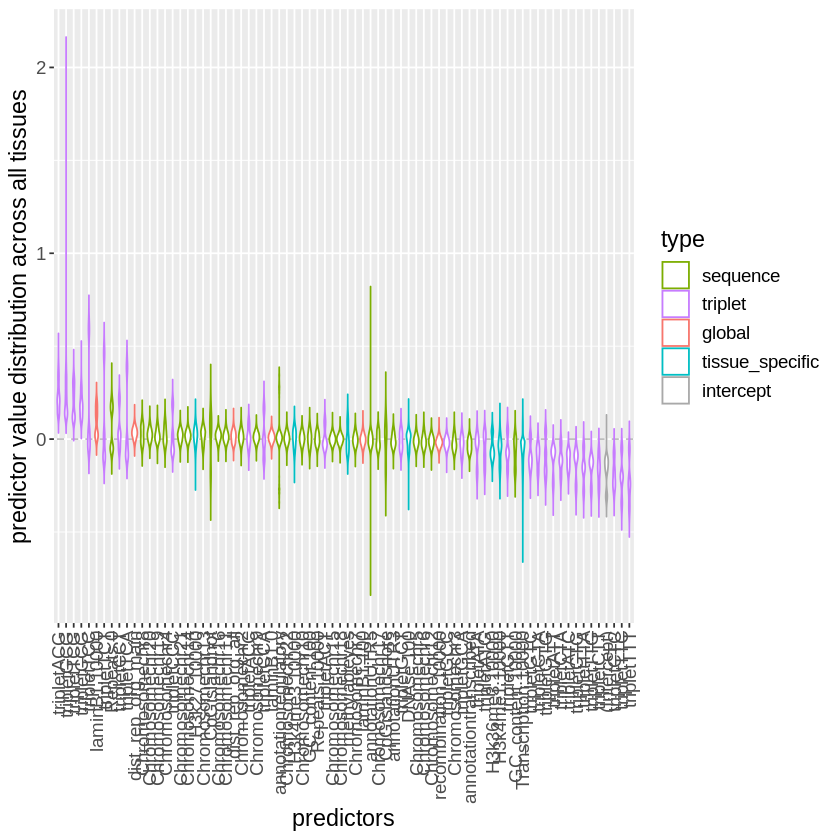

In [86]:
library(tidyr)

p<-ggplot(all_all_coefs_long, aes(x =reorder(name, -all_mean_est), y = coeficient,color=type)) + #http://www.sthda.com/english/wiki/ggplot2-violin-plot-quick-start-guide-r-software-and-data-visualization
    geom_abline(intercept=0, slope=0, col="grey",linetype="dashed")+
    geom_violin()+
#     geom_point()+
    xlab(paste("predictors",sep=" "))+
    ylab("predictor value distribution across all tissues")+
    theme(text = element_text(size=14),axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+
    scale_color_manual(values=colors_ggplot)
ggsave(plot = p, width = 15, height = 10, dpi = 300, filename = paste(tmp_file_path,"analysis/global/plots/",model_name,"/coefViolinPlot_all_coefDev",model_desc_modify,"_all.pdf",sep=""))
p